In [231]:
from enum import Enum
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
import folium

import io
from PIL import Image

import plotly.graph_objects as go
# from plotly.subplots import make_subplot

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

In [237]:
class In(Enum):
    SINGAPORE = "singapore"
    SAN_FRANCISCO = "san francisco"
    COSTS = 2
    DIST = 3

### mobility data

In [7]:
cols = ["districts", "dist_public", "dist_driving", "dist_walking", "dist_cycling", "cost_bus","cost_subway", "cost_driving", "cost_cycling", "cost_walking"]

def read_sheet(city):
    if city == In.SINGAPORE:
        header=2
        nrows=31
    else:
        header=38
        nrows=37
    df = pd.read_excel("sheets/mobility_qol.xlsx", sheet_name=0, header=header, usecols="E, I:Q", nrows=nrows)
    df.columns = cols
    df.drop(0, inplace=True)

    return df 

In [8]:
sing_df = read_sheet(In.SINGAPORE)
sf_df = read_sheet(In.SAN_FRANCISCO)
sf_df.head()

,districts,dist_public,dist_driving,dist_walking,dist_cycling,cost_bus,cost_subway,cost_driving,cost_cycling,cost_walking
1,Bernal Heights,3.938473,26.517003,1.940619,5.829403,0.09,0.09,0.28,0.44,0.51
2,Castro/Upper Market,0.000000,0.000000,0.000000,0.000000,0.10,0.10,0.27,0.43,0.57
3,Chinatown,1.179977,15.022439,2.281854,7.834494,0.09,0.09,0.28,0.21,0.23
4,Crocker Amazon,5.642908,21.725930,2.340712,5.078145,0.08,0.08,0.29,0.48,0.48
5,Diamond Heights/Glen Park,8.617236,24.357509,2.215848,5.767667,0.09,0.09,0.28,0.48,0.55


### location data

In [85]:
def get_spatial_data(city):  
    city_name = "singapore" if city == In.SINGAPORE else "san francisco"
    path = f"{city_name}/coords.csv"
    coords_df = pd.read_csv(path)

    if city == In.SAN_FRANCISCO:
        mask = (coords_df['Longitude'] <= -122) & (coords_df['Latitude'] >= 37)
        coords_df = coords_df.loc[mask].reset_index(drop=True)
        
    if city == In.SINGAPORE:
        coords_df.drop(30, inplace=True)
    
    # reorganize and rename columns as needed 
    coords_df = coords_df[["Unnamed: 0",  "Latitude", "Longitude",]]
    coords_df.rename(columns={"Unnamed: 0": "districts"}, inplace=True)

    # k means 
    np_data = coords_df.iloc[:, 1:].to_numpy()
    kmeans = KMeans(n_clusters=4, n_init="auto").fit(np_data)

    # plot k means 
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=coords_df["Latitude"], 
        y=coords_df["Longitude"],
        mode='markers',
        marker=dict(
            color=kmeans.labels_,
            showscale=True,
            size=16
        )
    ))

    coords_df["space_group"] = kmeans.labels_

    return coords_df, fig
    # districts = list(districts_df[city])
    # coords = {}

#### map 

In [260]:
def make_map(sdf, city_enum, zoom=12):
    colors = ["blue", 'orange', 'green', "red"]
    colors_dict = {k:v for k,v in enumerate(colors)}
    sdf_colors = sdf["space_group"].apply(lambda x: colors_dict[x])

    markers = [folium.Marker(location=[lat, long],popup=name,icon=folium.Icon(color=color)) for lat, long, name, color in zip(sdf["Latitude"],  sdf["Longitude"], sdf["districts"], sdf_colors )]

    geolocator = Nominatim(user_agent="location_details")
    location = geolocator.geocode(city_enum.value)
    sing_loc = (location.latitude, location.longitude)

    map=folium.Map(location=sing_loc,zoom_start=zoom)
    for i in markers:
        map.add_child(i)


    return map 

In [274]:
def get_data_and_make_map(city_enum, zoom=12):
    df, fig = get_spatial_data(city_enum)
    # return df
    map = make_map(df, city_enum, zoom)
    return map

def save_map(m, name="map01"):
    img_data = m._to_png(15)
    img = Image.open(io.BytesIO(img_data))
    img.save(f'figures/{name}.png')

In [277]:
m = get_data_and_make_map(In.SAN_FRANCISCO, 13)
m

In [278]:
save_map(m, name="sf01")

In [266]:
m2 = get_data_and_make_map(In.SINGAPORE, 12)
m2

In [279]:
save_map(m2, name="sing01")

### distribution 

In [254]:
def mob_plot(an_df):
    
    sns.set()
    palette = sns.color_palette("bright")[0:4]
    n_rows=4
    n_cols=1
    # Create the subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[10,9], sharex=True )

    column_names = ["Public Transport", "Driving", "Walking", "Cycling"]

    for (i, column), name in zip(enumerate(an_df.columns[0:4]), column_names):
        g = sns.kdeplot(an_df, x=column ,ax=axes[i], hue="space_group", fill=True, palette=palette )
        axes[i].set_title(name)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        if i != 0:
            axes[i].get_legend().remove()
        elif i == 0:
            axes[i].get_legend().set_title("Area")
    
    return fig



def distance_plot(df, type=None):
    if type == In.COSTS:
        an_df = df.iloc[:, 5:]
    elif type == In.DIST:
        an_df = df.iloc[:, 1:5]
    else:
        an_df = df.iloc[:, 1:]
    
    an_df["space_group"] = df["space_group"]
    # return an_df

    # s = sns.pairplot(an_df, hue="space_group")
    s = mob_plot(an_df)
    
    return (s, an_df)

def merge_data(df_coords, df_mob):
    df = pd.merge(df_mob, df_coords,  on=['districts'], how='inner')
    return df


def make_dist(city_enum):
    df_coords, fig = get_spatial_data(city_enum)
    df_mob = read_sheet(city_enum)
    merged_df = merge_data(df_coords, df_mob)
    mob, df2 = distance_plot(merged_df, city_enum)

    return mob

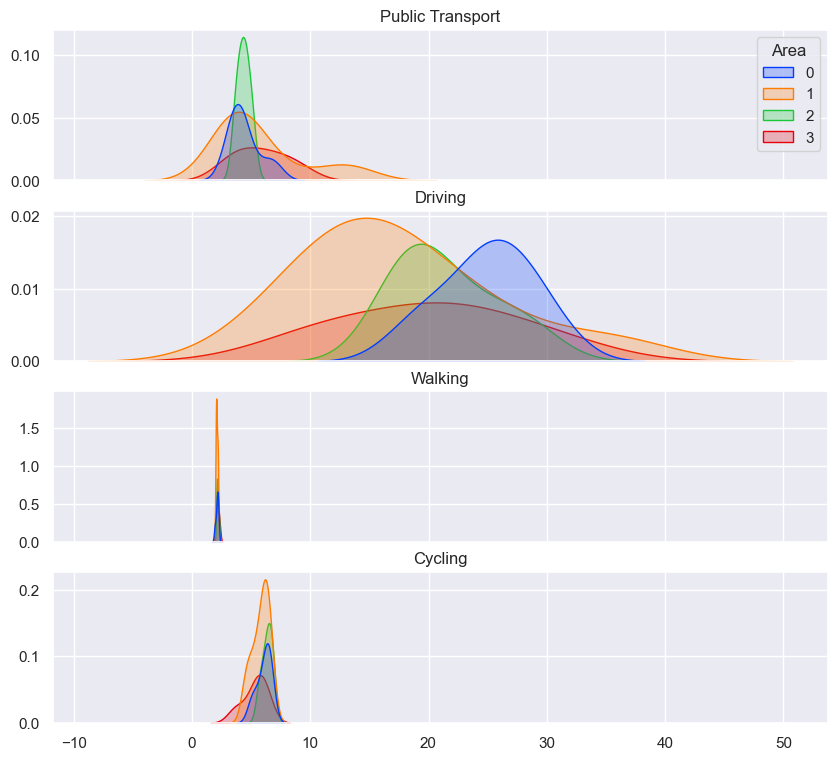

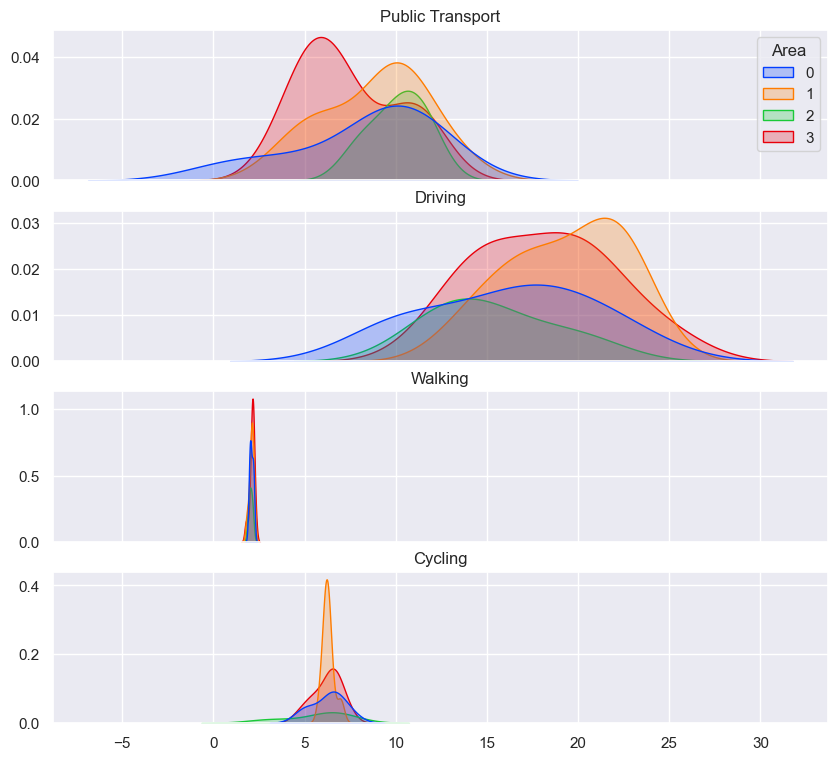

In [280]:
sf_mob = make_dist(In.SAN_FRANCISCO)
sing_mob = make_dist(In.SINGAPORE)